In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=2f4f943c6bc1e68208d49934f4cba04b3ea6a0316aefd7fc0d8240f343d19ca1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load functionality to manipulate dataframes
from pyspark.sql import functions as fn
import matplotlib.pyplot as plt
from pyspark.sql.functions import stddev, mean, col
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
# Functionality for computing features
from pyspark.ml import feature, regression, classification, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, VectorAssembler, HashingTF, Word2Vec, StringIndexer, OneHotEncoder
from pyspark.ml import clustering
from itertools import chain
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import classification
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
import time
#Classification report
from sklearn.metrics import classification_report, confusion_matrix
     


In [4]:
MAX_MEMORY = "45g"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/06 09:48:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# load master dataset
dfmaster = spark.read.format("csv").load("/kaggle/input/master/master.csv", delimiter = ",", header = True)

In [6]:

# create a 0/1 column for acquistions
dfmaster = dfmaster.\
  withColumn("labelacq", fn.when(col("status") == "acquired","1").otherwise("0"))

In [7]:
# number of rows in master table
print(dfmaster.count())

49444


In [8]:
dfmaster

DataFrame[_c0: string, permalink: string, name: string, market: string, funding_total_usd: string, status: string, country_code: string, city: string, funding_rounds: string, founded_year: string, quarter_new: string, age: string, permalink_agg: string, count_investor: string, time_to_first_funding: string, investor_country_codes: string, funding_round_types: string, total_raised_usd: string, permalink_sub: string, category_final: string, perma: string, investor_country_code: string, permaround: string, funding_round_type: string, labelacq: string]

In [9]:
# check for missing values 
dfmaster.toPandas().isnull().sum()

24/05/06 09:50:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , permalink, name, market, funding_total_usd, status, country_code, city, funding_rounds, founded_year, quarter_new, age, permalink_agg, count_investor, time_to_first_funding, investor_country_codes, funding_round_types, total_raised_usd, permalink_sub, category_final, perma, investor_country_code, permaround, funding_round_type
 Schema: _c0, permalink, name, market, funding_total_usd, status, country_code, city, funding_rounds, founded_year, quarter_new, age, permalink_agg, count_investor, time_to_first_funding, investor_country_codes, funding_round_types, total_raised_usd, permalink_sub, category_final, perma, investor_country_code, permaround, funding_round_type
Expected: _c0 but found: 
CSV file: file:///kaggle/input/master/master.csv


_c0                           0
permalink                     0
name                          0
market                     3966
funding_total_usd             0
status                     1314
country_code               5272
city                       6115
funding_rounds                0
founded_year              10955
quarter_new               10955
age                       10955
permalink_agg                 0
count_investor                0
time_to_first_funding     24730
investor_country_codes    20953
funding_round_types       17109
total_raised_usd          49434
permalink_sub                 0
category_final            45454
perma                     20953
investor_country_code     20953
permaround                17109
funding_round_type        17109
labelacq                      0
dtype: int64

In [10]:
# drop market columns because of too many level and better breakdown with the category_final column
dfmaster1 = dfmaster.drop("market")
     

In [11]:
dfmaster1 = dfmaster1.toPandas()
dfmaster1

24/05/06 09:50:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , permalink, name, funding_total_usd, status, country_code, city, funding_rounds, founded_year, quarter_new, age, permalink_agg, count_investor, time_to_first_funding, investor_country_codes, funding_round_types, total_raised_usd, permalink_sub, category_final, perma, investor_country_code, permaround, funding_round_type
 Schema: _c0, permalink, name, funding_total_usd, status, country_code, city, funding_rounds, founded_year, quarter_new, age, permalink_agg, count_investor, time_to_first_funding, investor_country_codes, funding_round_types, total_raised_usd, permalink_sub, category_final, perma, investor_country_code, permaround, funding_round_type
Expected: _c0 but found: 
CSV file: file:///kaggle/input/master/master.csv


,_c0,permalink,name,funding_total_usd,status,country_code,city,funding_rounds,founded_year,quarter_new,...,investor_country_codes,funding_round_types,total_raised_usd,permalink_sub,category_final,perma,investor_country_code,permaround,funding_round_type,labelacq
0,0,/organization/aster-data-systems,Aster Data Systems,"53,000,000",acquired,USA,San Carlos,4,2005,Q3,...,"USA, USA, USA, USA, USA, USA, USA, USA, USA, U...","venture, venture, venture, venture, venture, v...",None,/organization/aster-data-systems,None,/organization/aster-data-systems,USA,/organization/aster-data-systems,venture,1
1,1,/organization/bunker-mode,Bunker Mode,"200,000",operating,USA,San Francisco,1,2012,Q1,...,None,None,None,/organization/bunker-mode,None,None,None,None,None,0
2,2,/organization/redgage,Redgage,"397,000",operating,USA,Hollywood,1,2007,Q1,...,None,None,None,/organization/redgage,None,None,None,None,None,0
3,3,/organization/craigslist,Craigslist,"13,500,000",operating,USA,San Francisco,1,1995,Q1,...,USA,venture,None,/organization/craigslist,None,/organization/craigslist,USA,/organization/craigslist,venture,0
4,4,/organization/mountainside-fitness,Mountainside Fitness,"40,000,000",operating,USA,Scottsdale,1,1991,Q1,...,None,None,None,/organization/mountainside-fitness,None,None,None,None,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49439,49439,/organization/rezdy,Rezdy,"1,000,000",operating,AUS,Sydney,1,2011,Q2,...,None,"venture, venture, venture",None,/organization/rezdy,None,None,None,/organization/rezdy,venture,0
49440,49440,/organization/soak-smart-operational-agricultu...,SOAK (Smart Operational Agricultural toolKit),"25,000",operating,None,None,1,2008,Q1,...,None,None,None,/organization/soak-smart-operational-agricultu...,None,None,None,None,None,0
49441,49441,/organization/scour-prevention,Scour Prevention,"1,048,954",operating,GBR,Lowestoft,2,None,None,...,"GBR, GBR","angel, undisclosed",None,/organization/scour-prevention,None,/organization/scour-prevention,GBR,/organization/scour-prevention,angel,0
49442,49442,/organization/witoi,WITOI,"40,000",operating,CHL,Santiago,1,2012,Q1,...,CHL,seed,None,/organization/witoi,None,/organization/witoi,CHL,/organization/witoi,seed,0


In [12]:
# Replace NaN with mode for categorical variables
dfmaster1['total_raised_usd'] = dfmaster1['total_raised_usd'].fillna(dfmaster1['total_raised_usd'].mode()[0])
dfmaster1['time_to_first_funding'] = dfmaster1['time_to_first_funding'].fillna(dfmaster1['time_to_first_funding'].mode()[0])
dfmaster1['founded_year'] = dfmaster1['founded_year'].fillna(dfmaster1['founded_year'].mode()[0])
dfmaster1['age'] = dfmaster1['age'].fillna(dfmaster1['age'].mode()[0])
dfmaster1['status'] = dfmaster1['status'].fillna(dfmaster1['status'].mode()[0])
dfmaster1['country_code'] = dfmaster1['country_code'].fillna(dfmaster1['country_code'].mode()[0])
dfmaster1['city'] = dfmaster1['city'].fillna(dfmaster1['city'].mode()[0])
dfmaster1['quarter_new'] = dfmaster1['quarter_new'].fillna(dfmaster1['quarter_new'].mode()[0])
dfmaster1['investor_country_codes'] = dfmaster1['investor_country_codes'].fillna(dfmaster1['investor_country_codes'].mode()[0])
dfmaster1['funding_round_types'] = dfmaster1['funding_round_types'].fillna(dfmaster1['funding_round_types'].mode()[0])
dfmaster1['permaround'] = dfmaster1['permaround'].fillna(dfmaster1['permaround'].mode()[0])
dfmaster1['investor_country_code'] = dfmaster1['investor_country_code'].fillna(dfmaster1['investor_country_code'].mode()[0])
dfmaster1['funding_round_type'] = dfmaster1['funding_round_type'].fillna(dfmaster1['funding_round_type'].mode()[0])
dfmaster1['category_final'] = dfmaster1['category_final'].fillna(dfmaster1['category_final'].mode()[0])
dfmaster1['perma'] = dfmaster1['perma'].fillna(dfmaster1['perma'].mode()[0])
   

In [13]:
# check for missing values 
dfmaster1.isnull().sum()
     

_c0                       0
permalink                 0
name                      0
funding_total_usd         0
status                    0
country_code              0
city                      0
funding_rounds            0
founded_year              0
quarter_new               0
age                       0
permalink_agg             0
count_investor            0
time_to_first_funding     0
investor_country_codes    0
funding_round_types       0
total_raised_usd          0
permalink_sub             0
category_final            0
perma                     0
investor_country_code     0
permaround                0
funding_round_type        0
labelacq                  0
dtype: int64

In [14]:
# drop rows with missing values
dfmaster1drop = dfmaster1.dropna()

In [15]:

print(dfmaster1drop.count())

_c0                       49444
permalink                 49444
name                      49444
funding_total_usd         49444
status                    49444
country_code              49444
city                      49444
funding_rounds            49444
founded_year              49444
quarter_new               49444
age                       49444
permalink_agg             49444
count_investor            49444
time_to_first_funding     49444
investor_country_codes    49444
funding_round_types       49444
total_raised_usd          49444
permalink_sub             49444
category_final            49444
perma                     49444
investor_country_code     49444
permaround                49444
funding_round_type        49444
labelacq                  49444
dtype: int64


In [16]:

sql = SQLContext(spark)

/opt/conda/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [17]:
dfmaster2 = sql.createDataFrame(dfmaster1drop)


In [18]:
display(dfmaster2)


DataFrame[_c0: string, permalink: string, name: string, funding_total_usd: string, status: string, country_code: string, city: string, funding_rounds: string, founded_year: string, quarter_new: string, age: string, permalink_agg: string, count_investor: string, time_to_first_funding: string, investor_country_codes: string, funding_round_types: string, total_raised_usd: string, permalink_sub: string, category_final: string, perma: string, investor_country_code: string, permaround: string, funding_round_type: string, labelacq: string]

In [19]:
# create index for categorical variables
# use pipeline to apply indexer
list1 = ["country_code","city","quarter_new","investor_country_code","funding_round_type","category_final"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(dfmaster2) for column in list1]
pipelineindex = Pipeline(stages=indexers).fit(dfmaster2)
dfmasternew = pipelineindex.transform(dfmaster2)

24/05/06 09:52:29 WARN TaskSetManager: Stage 6 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:52:34 WARN TaskSetManager: Stage 9 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:52:35 WARN TaskSetManager: Stage 12 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:52:36 WARN TaskSetManager: Stage 15 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:52:37 WARN TaskSetManager: Stage 18 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:52:39 WARN TaskSetManager: Stage 21 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


In [20]:
# convert string to double for numerical variables
dfmasternew = dfmasternew.\
  withColumn("numeric_funding_rounds", dfmasternew["funding_rounds"].cast("int")).\
  withColumn("numeric_age", dfmasternew["age"].cast("int")).\
  withColumn("numeric_count_investor", dfmasternew["count_investor"].cast("int")).\
  withColumn("numeric_time_to_first_funding", dfmasternew["time_to_first_funding"].cast("int")).\
  withColumn("numeric_total_raised_usd", dfmasternew["total_raised_usd"].cast("int")).\
  withColumn("label", dfmasternew["labelacq"].cast("int"))
    

In [21]:
dfmasternew = dfmasternew.\
  withColumn("funding_round_type", dfmasternew["funding_round_type"].cast("double")).\
  withColumn("country_code_index", dfmasternew["country_code_index"].cast("double")).\
  withColumn("city_index", dfmasternew["city_index"].cast("double")).\
  withColumn("quarter_new_index", dfmasternew["quarter_new_index"].cast("double")).\
  withColumn("labelacq", dfmasternew["labelacq"].cast("double"))

In [22]:
# save
dfone = dfmasternew

In [23]:
display(dfone)

DataFrame[_c0: string, permalink: string, name: string, funding_total_usd: string, status: string, country_code: string, city: string, funding_rounds: string, founded_year: string, quarter_new: string, age: string, permalink_agg: string, count_investor: string, time_to_first_funding: string, investor_country_codes: string, funding_round_types: string, total_raised_usd: string, permalink_sub: string, category_final: string, perma: string, investor_country_code: string, permaround: string, funding_round_type: double, labelacq: double, country_code_index: double, city_index: double, quarter_new_index: double, investor_country_code_index: double, funding_round_type_index: double, category_final_index: double, numeric_funding_rounds: int, numeric_age: int, numeric_count_investor: int, numeric_time_to_first_funding: int, numeric_total_raised_usd: int, label: int]

In [24]:
print(dfone.count())

24/05/06 09:53:37 WARN TaskSetManager: Stage 24 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


49444


In [25]:
# list of index columns of categorical variables for the onehotencoder
list2 = dfone.columns[24:30]
list2

['country_code_index',
 'city_index',
 'quarter_new_index',
 'investor_country_code_index',
 'funding_round_type_index',
 'category_final_index']

In [26]:

# create sparse matrix of indexed categorical columns
# use pipline to apply the encoder
onehotencoder_stages = [OneHotEncoder(inputCol=c, outputCol='onehotencoded_' + c) for c in list2]
pipelineonehot = Pipeline(stages=onehotencoder_stages)
pipeline_mode = pipelineonehot.fit(dfone)
df_coded = pipeline_mode.transform(dfone)

24/05/06 09:57:05 WARN TaskSetManager: Stage 27 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:57:07 WARN TaskSetManager: Stage 28 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:57:08 WARN TaskSetManager: Stage 29 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


In [27]:
display(df_coded)

DataFrame[_c0: string, permalink: string, name: string, funding_total_usd: string, status: string, country_code: string, city: string, funding_rounds: string, founded_year: string, quarter_new: string, age: string, permalink_agg: string, count_investor: string, time_to_first_funding: string, investor_country_codes: string, funding_round_types: string, total_raised_usd: string, permalink_sub: string, category_final: string, perma: string, investor_country_code: string, permaround: string, funding_round_type: double, labelacq: double, country_code_index: double, city_index: double, quarter_new_index: double, investor_country_code_index: double, funding_round_type_index: double, category_final_index: double, numeric_funding_rounds: int, numeric_age: int, numeric_count_investor: int, numeric_time_to_first_funding: int, numeric_total_raised_usd: int, label: int, onehotencoded_country_code_index: vector, onehotencoded_city_index: vector, onehotencoded_quarter_new_index: vector, onehotencoded

In [29]:
# split dataset into training, validaiton and testing dataset
training_df, validation_df, testing_df = df_coded.randomSplit([0.6, 0.3, 0.1])

In [30]:
training_df.columns[30:35]


['numeric_funding_rounds',
 'numeric_age',
 'numeric_count_investor',
 'numeric_time_to_first_funding',
 'numeric_total_raised_usd']

In [31]:
training_df.columns[36:42]


['onehotencoded_country_code_index',
 'onehotencoded_city_index',
 'onehotencoded_quarter_new_index',
 'onehotencoded_investor_country_code_index',
 'onehotencoded_funding_round_type_index',
 'onehotencoded_category_final_index']

In [99]:
training_df.columns

['_c0',
 'permalink',
 'name',
 'funding_total_usd',
 'status',
 'country_code',
 'city',
 'funding_rounds',
 'founded_year',
 'quarter_new',
 'age',
 'permalink_agg',
 'count_investor',
 'time_to_first_funding',
 'investor_country_codes',
 'funding_round_types',
 'total_raised_usd',
 'permalink_sub',
 'category_final',
 'perma',
 'investor_country_code',
 'permaround',
 'funding_round_type',
 'labelacq',
 'country_code_index',
 'city_index',
 'quarter_new_index',
 'investor_country_code_index',
 'funding_round_type_index',
 'category_final_index',
 'numeric_funding_rounds',
 'numeric_age',
 'numeric_count_investor',
 'numeric_time_to_first_funding',
 'numeric_total_raised_usd',
 'label',
 'onehotencoded_country_code_index',
 'onehotencoded_city_index',
 'onehotencoded_quarter_new_index',
 'onehotencoded_investor_country_code_index',
 'onehotencoded_funding_round_type_index',
 'onehotencoded_category_final_index']

In [32]:
# define vector assembler with the features for the modelling
vastd = VectorAssembler(). \
      setInputCols(training_df.columns[30:35] + training_df.columns[36:42]). \
      setOutputCol('features_nonstd')
	  	  
std = feature.StandardScaler(withMean=True, withStd=True).setInputCol('features_nonstd').setOutputCol('features')
  

In [33]:
# suffix for investor country code because intersection with county_code of  the companies
invcc = ['{}_{}'.format(a, "investor") for a in indexers[3].labels]
  

In [34]:
# define labellist by using the indexer stages for displaying the weights & loadings
labellist = training_df.columns[30:35] + indexers[0].labels + indexers[1].labels + indexers[2].labels + invcc + indexers[4].labels + indexers[5].labels
 

In [35]:

# define multiclass classification evaluator
mce = MulticlassClassificationEvaluator()

In [36]:
dt_std = DecisionTreeClassifier(labelCol="label", featuresCol="features")


In [37]:
dt_pipeline_std = Pipeline(stages=[vastd, std, dt_std]).fit(training_df)


24/05/06 09:59:34 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/05/06 09:59:35 WARN TaskSetManager: Stage 30 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:59:39 WARN TaskSetManager: Stage 33 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:59:42 WARN TaskSetManager: Stage 36 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:59:43 WARN TaskSetManager: Stage 37 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 09:59:47 WARN TaskSetManager: Stage 38 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:00:03 WARN DAGScheduler: Broadcasting large task binary with size 1053.9 KiB
24/05/06 10:

In [79]:

sample_row = training_df.limit(1)

# Make prediction on the sample row
prediction = dt_pipeline_std.transform(sample_row)

# Show the prediction result
prediction.select("features", "prediction").show()


24/05/06 11:22:07 WARN TaskSetManager: Stage 1592 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[1.79760799705013...|       0.0|
+--------------------+----------+



In [38]:
dfdt_std = dt_pipeline_std.transform(validation_df)


In [39]:
# print the areas under the curve for the decision tree model pipeline
print("Decision Tree: AUC = {}".format(mce.evaluate(dfdt_std)))
 

24/05/06 10:00:11 WARN TaskSetManager: Stage 50 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


Decision Tree: AUC = 0.8936704670727241


In [40]:
# print the accuracies for the decision tree model pipeline
print(dfdt_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Decision Tree")).show())


24/05/06 10:00:22 WARN TaskSetManager: Stage 52 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+--------------------------+
|Accuracy for Decision Tree|
+--------------------------+
|        0.9277304100690216|
+--------------------------+

None


In [41]:
gbt_std = GBTClassifier(labelCol="label", featuresCol="features", maxIter=100)


In [42]:
gbt_pipeline_std = Pipeline(stages=[vastd, std, gbt_std]).fit(training_df)


24/05/06 10:01:23 WARN TaskSetManager: Stage 55 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:01:25 WARN TaskSetManager: Stage 58 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:01:26 WARN TaskSetManager: Stage 59 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:01:28 WARN TaskSetManager: Stage 60 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:01:40 WARN DAGScheduler: Broadcasting large task binary with size 1020.3 KiB
24/05/06 10:01:40 WARN TaskSetManager: Stage 62 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:01:43 WARN DAGScheduler: Broadcasting large task binary with size 1021.0 KiB
24/05/06 10:01:43 WARN TaskSetManager: Stage 64 contains a task of very large size (3176 KiB). The maximum recom

In [43]:
dfgbt_std = gbt_pipeline_std.transform(validation_df)


In [44]:
# print the areas under the curve for the gradient boosted trees model pipeline
print("Gradient Boosted Trees: AUC = {}".format(mce.evaluate(dfgbt_std)))
  

24/05/06 10:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1511.2 KiB
24/05/06 10:05:40 WARN TaskSetManager: Stage 1062 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:05:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Gradient Boosted Trees: AUC = 0.8984025813904528


In [45]:
# print the accuracies for the gradient boosted trees model pipeline
print(dfgbt_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Gradient Boosted Tree")).show())
 

24/05/06 10:05:56 WARN DAGScheduler: Broadcasting large task binary with size 1503.9 KiB
24/05/06 10:05:56 WARN TaskSetManager: Stage 1064 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+----------------------------------+
|Accuracy for Gradient Boosted Tree|
+----------------------------------+
|                0.9269183922046285|
+----------------------------------+

None


In [46]:
# define binary classification evaluator
bce = BinaryClassificationEvaluator()
 

In [47]:
rfstd = RandomForestClassifier(numTrees=25, maxBins=10000, featuresCol='features', labelCol='label')
rf_pipeline_std = Pipeline(stages=[vastd, std, rfstd]).fit(training_df)
dfrf_std = rf_pipeline_std.transform(validation_df)
print("Random Forest 25 trees: AUC = {}".format(bce.evaluate(dfrf_std)))
print(dfrf_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Random Forest with 25 trees")).show())
rfw_std = spark.createDataFrame(pd.DataFrame(list(zip(labellist, rf_pipeline_std.stages[2].featureImportances.toArray())),
            columns = ['column', 'importancy']).sort_values('importancy').tail(20))
     

24/05/06 10:06:31 WARN TaskSetManager: Stage 1067 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:06:32 WARN TaskSetManager: Stage 1070 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:06:34 WARN TaskSetManager: Stage 1073 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:06:35 WARN TaskSetManager: Stage 1074 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:06:37 WARN TaskSetManager: Stage 1075 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1048.1 KiB
24/05/06 10:07:11 WARN TaskSetManager: Stage 1077 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:07:14 WARN DAGScheduler: Broadcasti

Random Forest 25 trees: AUC = 0.6805289029562634


24/05/06 10:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
24/05/06 10:07:20 WARN TaskSetManager: Stage 1098 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+----------------------------------------+
|Accuracy for Random Forest with 25 trees|
+----------------------------------------+
|                      0.9280687508458519|
+----------------------------------------+

None


In [48]:
rfw_std.show()


+--------------------+--------------------+
|              column|          importancy|
+--------------------+--------------------+
|                Oulu|0.014472309946536048|
|         Neutral Bay|0.014585666950051274|
|             Redmond|0.014691443605781666|
|             Tianjin| 0.01521699835517618|
|           Montrouge|0.015251572044312838|
|           Cambridge|0.015323795714475988|
|              Dublin|0.015931867126621924|
|                 MAF|0.017326034797588825|
|          Warminster|0.017925546849726682|
|     Fort Lauderdale|0.018670394083959586|
|           Singapore| 0.01916024485660696|
|           Glen Cove|0.019256196698987316|
|            Camborne|0.025328031827467234|
|         Los Angeles|0.027359346061628965|
|               Mafra|0.028848144474719253|
|        MAR_investor|0.030499043754586154|
|numeric_funding_r...| 0.03202975300553946|
|                 USA|0.048515414752959965|
|            San Jose| 0.05603670215645547|
|numeric_time_to_f...| 0.0742874

In [49]:
lambda_par_std = 0.05
alpha_par_std = 0.05
en_lr_std = LogisticRegression().\
        setLabelCol('label').\
        setFeaturesCol('features').\
        setRegParam(lambda_par_std).\
        setElasticNetParam(alpha_par_std)

In [50]:
en_lr_estimator_std = Pipeline(stages=[vastd, std, en_lr_std])
en_lr_model_std = en_lr_estimator_std.fit(training_df)
dfmodel_std = en_lr_model_std.transform(validation_df)
print("Logistic Regression Model: AUC = {}".format(bce.evaluate(dfmodel_std)))	
print(dfmodel_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Model")).show())
     

24/05/06 10:07:45 WARN TaskSetManager: Stage 1103 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:07:47 WARN TaskSetManager: Stage 1106 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:07:56 WARN TaskSetManager: Stage 1107 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:08:03 WARN TaskSetManager: Stage 1108 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:08:03 WARN TaskSetManager: Stage 1109 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:08:04 WARN TaskSetManager: Stage 1110 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:08:04 WARN TaskSetManager: Stage 1111 contains a task of very large size (3176 KiB). The maximum recommended task size is 10

Logistic Regression Model: AUC = 0.7338627804496107


24/05/06 10:08:12 WARN TaskSetManager: Stage 1138 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+------------------+
|Accuracy for Model|
+------------------+
|0.9274597374475572|
+------------------+

None


In [51]:
pd.DataFrame(list(zip(labellist, en_lr_model_std.stages[2].coefficients.toArray())),
            columns = ['label', 'weight']).sort_values('weight').tail(40)
   

,label,weight
2179,Wollongong,0.016169
284,Cologne,0.016439
4265,Wyoming,0.016484
2748,Essex Junction,0.016502
1622,Bradford,0.016842
367,Newcastle Upon Tyne,0.017002
474,Düsseldorf,0.017144
2610,Cottage Grove,0.017451
123,Palo Alto,0.017649
706,Seminole,0.017683


In [52]:

pd.DataFrame(list(zip(labellist, en_lr_model_std.stages[2].coefficients.toArray())),
            columns = ['label', 'weight']).sort_values('weight').head(10)

,label,weight
4387,MAR_investor,-0.056757
11,IND,-0.032800
4312,USA_investor,-0.032124
4392,undisclosed,-0.030715
8,CHN,-0.028622
4316,DEU_investor,-0.023118
4319,CHL_investor,-0.010479
158,Barcelona,-0.007908
4314,FRA_investor,-0.006609
4308,Q1,-0.006469


In [53]:
# define evaluators for accuracy and area under the curve
evaluator = evaluation.MulticlassClassificationEvaluator(metricName="accuracy")
evaluatorauc = evaluation.MulticlassClassificationEvaluator()

mlp_std = classification.MultilayerPerceptronClassifier(seed=0).\
    setStepSize(0.2).\
    setMaxIter(200).\
    setFeaturesCol('features').\
    setLayers([4399,30,30,30, 2])
	
mlp_std_model = Pipeline(stages=[vastd, std, mlp_std]).fit(training_df)
dfnn_std = mlp_std_model.transform(validation_df)
print("NN Model with 3 hidden layers and 30 neurons each: Accuracy = {}".format(evaluator.evaluate(dfnn_std)))
print("NN Model with 3 hidden layers and 30 neurons each: AUC = {}".format(evaluatorauc.evaluate(dfnn_std)))
     

24/05/06 10:09:28 WARN TaskSetManager: Stage 1141 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:09:30 WARN TaskSetManager: Stage 1144 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:09:33 WARN TaskSetManager: Stage 1145 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:09:36 WARN TaskSetManager: Stage 1146 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:09:38 WARN TaskSetManager: Stage 1147 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:09:40 WARN TaskSetManager: Stage 1148 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:09:42 WARN TaskSetManager: Stage 1149 contains a task of very large size (3176 KiB). The maximum recommended task size is 10

NN Model with 3 hidden layers and 30 neurons each: Accuracy = 0.9026255244282041


24/05/06 10:17:06 WARN DAGScheduler: Broadcasting large task binary with size 1983.5 KiB
24/05/06 10:17:06 WARN TaskSetManager: Stage 1377 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


NN Model with 3 hidden layers and 30 neurons each: AUC = 0.890998640404737


In [54]:
pca_std = feature.PCA(k=1500, inputCol='features', outputCol='pca_feat')
en_lr_estimator_std_pca = Pipeline(
    stages=[vastd, std, pca_std, en_lr_std])
en_lr_model_std_pca = en_lr_estimator_std_pca.fit(training_df)
varlist_std =en_lr_model_std_pca.stages[2].explainedVariance
npvar_std = np.cumsum(varlist_std[1000:1500])
# 0.7 as starting point because we start at 1000
# was found in other analysis
npvar_std = [x+0.7 for x in npvar_std]
pci_std = [pci_std for pci_std in range(1000,1500,1)]
dfvar_std = spark.createDataFrame(pd.DataFrame({"Number of PCs": pci_std, "Cumlative Variance Explained": npvar_std}))
display(dfvar_std)

24/05/06 10:17:10 WARN TaskSetManager: Stage 1379 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:17:11 WARN TaskSetManager: Stage 1382 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:17:12 WARN TaskSetManager: Stage 1383 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:17:13 WARN TaskSetManager: Stage 1384 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:17:18 WARN TaskSetManager: Stage 1385 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:17:19 WARN TaskSetManager: Stage 1386 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:19:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/05/06 10:27:10 WARN Ta

DataFrame[Number of PCs: bigint, Cumlative Variance Explained: double]

In [55]:
dfvar_std.show()


+-------------+----------------------------+
|Number of PCs|Cumlative Variance Explained|
+-------------+----------------------------+
|         1000|          0.7002705029782811|
|         1001|          0.7005410059565623|
|         1002|          0.7008115089348435|
|         1003|          0.7010820119131246|
|         1004|          0.7013525148914058|
|         1005|           0.701623017869687|
|         1006|          0.7018935208479681|
|         1007|          0.7021640238262493|
|         1008|          0.7024345268045304|
|         1009|          0.7027050297828116|
|         1010|          0.7029755327610927|
|         1011|          0.7032460357393739|
|         1012|          0.7035165387176551|
|         1013|          0.7037870416959362|
|         1014|          0.7040575446742173|
|         1015|          0.7043280476524986|
|         1016|          0.7045985506307797|
|         1017|          0.7048690536090608|
|         1018|           0.705139556587342|
|         

In [56]:
pca_std = feature.PCA(k=1332, inputCol='features', outputCol='pca_feat')
en_lr_std_pca = LogisticRegression().\
        setLabelCol('label').\
        setFeaturesCol('pca_feat').\
        setRegParam(lambda_par_std).\
        setElasticNetParam(alpha_par_std)
en_lr_estimator_std_pca = Pipeline(
    stages=[vastd, std, pca_std, en_lr_std])
en_lr_model_std_pca = en_lr_estimator_std_pca.fit(training_df)
dfmodel_std_pca = en_lr_model_std_pca.transform(validation_df)
     

24/05/06 10:27:30 WARN TaskSetManager: Stage 1409 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:27:32 WARN TaskSetManager: Stage 1412 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:27:33 WARN TaskSetManager: Stage 1413 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:27:33 WARN TaskSetManager: Stage 1414 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:27:40 WARN TaskSetManager: Stage 1415 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:27:41 WARN TaskSetManager: Stage 1416 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:37:44 WARN TaskSetManager: Stage 1417 contains a task of very large size (3176 KiB). The maximum recommended task size is 10

In [57]:
print("Logistic Regression Model: AUC = {}".format(bce.evaluate(dfmodel_std_pca)))
print(dfmodel_std_pca.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Model 1")).show())
 

24/05/06 10:38:00 WARN TaskSetManager: Stage 1438 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


Logistic Regression Model: AUC = 0.7337437054347523


24/05/06 10:38:02 WARN TaskSetManager: Stage 1449 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+
|Accuracy for Model 1|
+--------------------+
|  0.9274597374475572|
+--------------------+

None


In [58]:
pc1 = en_lr_model_std_pca.stages[2].pc.toArray()[:, 0].tolist()
pc2 = en_lr_model_std_pca.stages[2].pc.toArray()[:, 1].tolist()
# create pandas df with the loadings/PCs and the corresponding labels
pc_loadings = pd.DataFrame([labellist, pc1, pc2]).T.rename(columns={0: 'label', 
                                                                          1: 'load_pc1',
                                                                          2: 'load_pc2',})
     


In [59]:
load1 = spark.createDataFrame(pd.concat((pc_loadings.sort_values('load_pc1').head(), 
           pc_loadings.sort_values('load_pc1').tail())))
display(load1)

DataFrame[label: string, load_pc1: double, load_pc2: double]

In [60]:
# create spark df with the 5 highest and lowest loadings of the second PC
load2 = spark.createDataFrame(pd.concat((pc_loadings.sort_values('load_pc2').head(), 
           pc_loadings.sort_values('load_pc2').tail())))
display(load2)

DataFrame[label: string, load_pc1: double, load_pc2: double]

In [61]:
print("Decision Tree Classifier")
# Decision Tree Classifier
dfdt_test_std = dt_pipeline_std.transform(testing_df)
print("Decision Tree: AUC = {}".format(mce.evaluate(dfdt_test_std)))
print(dfdt_test_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Decision Tree")).show())
auc_dt = mce.evaluate(dfdt_test_std)
     

Decision Tree Classifier


24/05/06 10:38:36 WARN TaskSetManager: Stage 1452 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


Decision Tree: AUC = 0.8934084216775084


24/05/06 10:38:38 WARN TaskSetManager: Stage 1454 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:38:39 WARN TaskSetManager: Stage 1457 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+--------------------------+
|Accuracy for Decision Tree|
+--------------------------+
|        0.9276369582992641|
+--------------------------+

None


In [72]:
# Assuming dt_pipeline_std is your trained Decision Tree pipeline model

# Save the model to disk
model_path = "decision_tree_model"
dt_pipeline_std.save(model_path)

In [62]:
dts_true = dfdt_test_std.select(['label']).collect()
dts_pred = dfdt_test_std.select(['prediction']).collect()
print(classification_report(dts_true, dts_pred))
     


24/05/06 10:38:44 WARN TaskSetManager: Stage 1459 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:38:45 WARN TaskSetManager: Stage 1460 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4539
           1       0.33      0.00      0.01       353

    accuracy                           0.93      4892
   macro avg       0.63      0.50      0.48      4892
weighted avg       0.89      0.93      0.89      4892



In [63]:
print("Gradient Boosted Trees Classifier")
# Gradient Boosted Trees Classifier
dfgbt_test_std = gbt_pipeline_std.transform(testing_df)
print("Gradient Boosted Trees: AUC = {}".format(mce.evaluate(dfgbt_test_std)))
print(dfgbt_test_std.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Gradient Boosted Trees")).show())
auc_gbt = mce.evaluate(dfgbt_test_std)
     

Gradient Boosted Trees Classifier


24/05/06 10:38:51 WARN DAGScheduler: Broadcasting large task binary with size 1511.2 KiB
24/05/06 10:38:51 WARN TaskSetManager: Stage 1461 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


Gradient Boosted Trees: AUC = 0.8995830406030789


24/05/06 10:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1503.9 KiB
24/05/06 10:38:53 WARN TaskSetManager: Stage 1463 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+-----------------------------------+
|Accuracy for Gradient Boosted Trees|
+-----------------------------------+
|                 0.9266148814390842|
+-----------------------------------+

None


24/05/06 10:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1511.2 KiB
24/05/06 10:38:54 WARN TaskSetManager: Stage 1466 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


In [73]:

# Save the model to disk
model_path = "gbt_model"
gbt_pipeline_std.save(model_path)

In [64]:
gbts_true = dfgbt_test_std.select(['label']).collect()
gbts_pred = dfgbt_test_std.select(['prediction']).collect()
print(classification_report(gbts_true, gbts_pred))

24/05/06 10:39:00 WARN TaskSetManager: Stage 1468 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:39:01 WARN DAGScheduler: Broadcasting large task binary with size 1492.3 KiB
24/05/06 10:39:01 WARN TaskSetManager: Stage 1469 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4539
           1       0.43      0.06      0.10       353

    accuracy                           0.93      4892
   macro avg       0.68      0.53      0.53      4892
weighted avg       0.90      0.93      0.90      4892



In [65]:
print("Random Forest Model with 25 trees")
# Random Forest Model with 25 trees
dfrf_std_test = rf_pipeline_std.transform(testing_df)
print("Random Forest 25 trees: AUC = {}".format(bce.evaluate(dfrf_std_test)))
print(dfrf_std_test.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Random Forest with 25 trees")).show())
auc_rf = bce.evaluate(dfrf_std_test)
     

Random Forest Model with 25 trees


24/05/06 10:39:07 WARN TaskSetManager: Stage 1470 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


Random Forest 25 trees: AUC = 0.6966438802022384


24/05/06 10:39:09 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB
24/05/06 10:39:09 WARN TaskSetManager: Stage 1481 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+----------------------------------------+
|Accuracy for Random Forest with 25 trees|
+----------------------------------------+
|                         0.9278413736713|
+----------------------------------------+

None


24/05/06 10:39:10 WARN TaskSetManager: Stage 1484 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


In [74]:

# Save the model to disk
model_path = "rf_model"
rf_pipeline_std.save(model_path)

In [66]:
rfs_true = dfrf_std_test.select(['label']).collect()
rfs_pred = dfrf_std_test.select(['prediction']).collect()
print(classification_report(rfs_true, rfs_pred))

24/05/06 10:39:17 WARN TaskSetManager: Stage 1495 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:39:18 WARN TaskSetManager: Stage 1496 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4539
           1       0.00      0.00      0.00       353

    accuracy                           0.93      4892
   macro avg       0.46      0.50      0.48      4892
weighted avg       0.86      0.93      0.89      4892



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [67]:

print("Logistic Regression Model with PCA")
# Logistic Regression Model with PCA
dfmodel_std_pca_test = en_lr_model_std_pca.transform(testing_df)
print("Logistic Regression Model: AUC = {}".format(bce.evaluate(dfmodel_std_pca_test)))
print(dfmodel_std_pca_test.select(fn.expr('float(label = prediction)').alias('correct')).select(fn.avg('correct').alias("Accuracy for Logistic Regression Model")).show())
auc_lr = bce.evaluate(dfmodel_std_pca_test)

Logistic Regression Model with PCA


24/05/06 10:39:25 WARN TaskSetManager: Stage 1497 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


Logistic Regression Model: AUC = 0.7438644745226606


24/05/06 10:39:27 WARN TaskSetManager: Stage 1508 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


+--------------------------------------+
|Accuracy for Logistic Regression Model|
+--------------------------------------+
|                    0.9276369582992641|
+--------------------------------------+

None


24/05/06 10:39:28 WARN TaskSetManager: Stage 1511 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


In [75]:

# Save the model to disk
model_path = "en_lr_model_std_pca"
en_lr_model_std_pca.save(model_path)

24/05/06 10:49:16 WARN TaskSetManager: Stage 1575 contains a task of very large size (46737 KiB). The maximum recommended task size is 1000 KiB.


In [68]:
lrs_true = dfmodel_std_pca_test.select(['label']).collect()
lrs_pred = dfmodel_std_pca_test.select(['prediction']).collect()
print(classification_report(lrs_true, lrs_pred))

24/05/06 10:39:33 WARN TaskSetManager: Stage 1522 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:39:34 WARN TaskSetManager: Stage 1523 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

           0       0.93      1.00      0.96      4539
           1       0.40      0.01      0.01       353

    accuracy                           0.93      4892
   macro avg       0.66      0.50      0.49      4892
weighted avg       0.89      0.93      0.89      4892



In [69]:

print("Neural Network Model")
# Neural Network Model
dfnntest_std = mlp_std_model.transform(testing_df)
print("NN Model with 3 hidden layers and 30 neurons each: Accuracy = {}".format(evaluator.evaluate(dfnntest_std)))
print("NN Model with 3 hidden layers and 30 neurons each: AUC = {}".format(evaluatorauc.evaluate(dfnntest_std)))
auc_nn = evaluatorauc.evaluate(dfnntest_std)

Neural Network Model


24/05/06 10:39:40 WARN DAGScheduler: Broadcasting large task binary with size 1983.5 KiB
24/05/06 10:39:40 WARN TaskSetManager: Stage 1524 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


NN Model with 3 hidden layers and 30 neurons each: Accuracy = 0.9076042518397384


24/05/06 10:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1983.5 KiB
24/05/06 10:39:42 WARN TaskSetManager: Stage 1526 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


NN Model with 3 hidden layers and 30 neurons each: AUC = 0.895891737338316


24/05/06 10:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1983.5 KiB
24/05/06 10:39:44 WARN TaskSetManager: Stage 1528 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


In [76]:

# Save the model to disk
model_path = "mlp_std_model"
mlp_std_model.save(model_path)

24/05/06 10:50:03 WARN TaskSetManager: Stage 1589 contains a task of very large size (1075 KiB). The maximum recommended task size is 1000 KiB.


In [70]:
nns_true = dfnntest_std.select(['label']).collect()
nns_pred = dfnntest_std.select(['prediction']).collect()
print(classification_report(nns_true, nns_pred))

24/05/06 10:39:51 WARN TaskSetManager: Stage 1530 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.
24/05/06 10:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1964.6 KiB
24/05/06 10:39:53 WARN TaskSetManager: Stage 1531 contains a task of very large size (3176 KiB). The maximum recommended task size is 1000 KiB.


              precision    recall  f1-score   support

           0       0.94      0.97      0.95      4539
           1       0.26      0.15      0.19       353

    accuracy                           0.91      4892
   macro avg       0.60      0.56      0.57      4892
weighted avg       0.89      0.91      0.90      4892



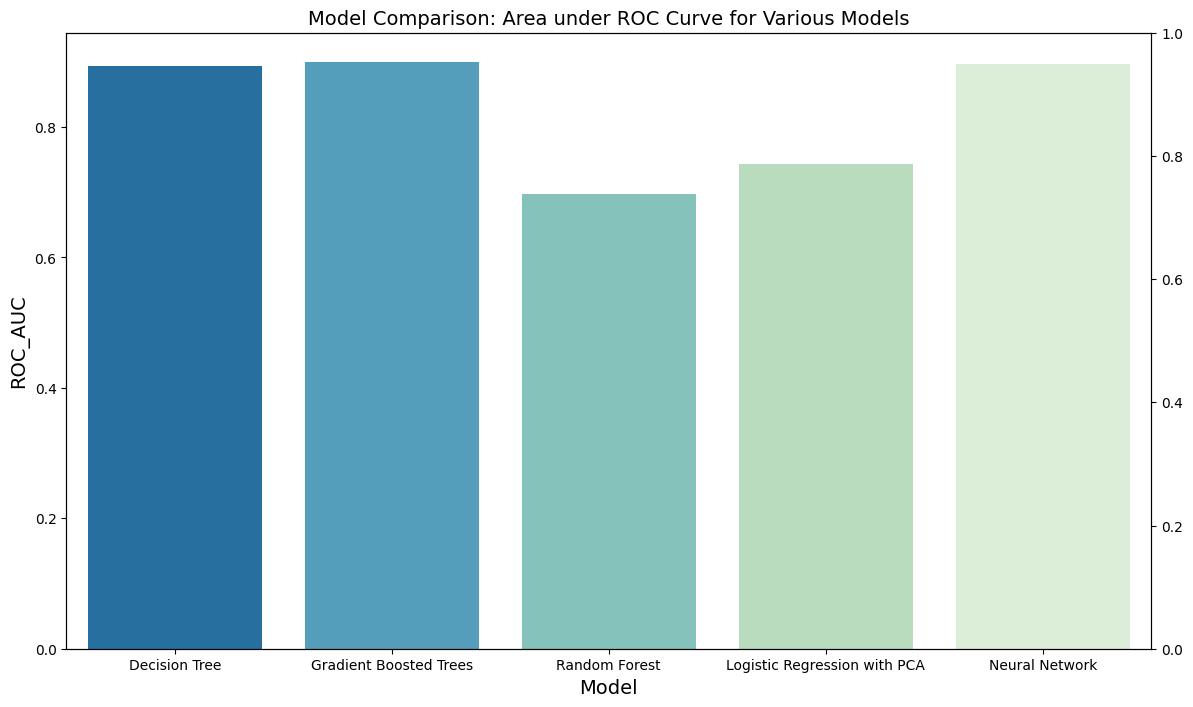

In [71]:
roc_auc_scores = [auc_dt, auc_gbt, auc_rf, auc_lr, auc_nn]

model_data = {'Model': ['Decision Tree','Gradient Boosted Trees','Random Forest','Logistic Regression with PCA','Neural Network'],
              'ROC_AUC': roc_auc_scores}
data = pd.DataFrame(model_data)

fig, ax1 = plt.subplots(figsize=(14,8))
ax1.set_title('Model Comparison: Area under ROC Curve for Various Models', fontsize=14)
ax1.set_xlabel('Model', fontsize=14)
ax1.set_ylabel('ROC_AUC', fontsize=14)
ax2 = sns.barplot(x='Model', y='ROC_AUC', data = data, palette='GnBu_r')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()